# Dashboard using Athena and Quicksight

## Overview

The datasets used for this project are found in __[this Kaggle dataset](https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce)__ and stored publicly in __my S3 bucket__(_s3://bucket-athena-quicksight/_). These datasets are transformed from Online Transaction Processing (__OLTP__) to Online Analytical Processing (__OLAP__). Converted datasets are saved as parquet files in this __S3 bucket__ (_s3://bucket-athena-quicksight/olap/_) and manually queried each dataset's schema to Athena (can be automated by running a crawler using AWS Glue). Finally, use the datasets to create visualizations using Quicksight.

## Dependencies

In [52]:
import boto3
import numpy as np
import pandas as pd
from io import BytesIO

## AWS Configuration

In [2]:
import configparser
config = configparser.ConfigParser()
config.read_file(open("cluster.config"))

In [3]:
KEY                     = config.get("AWS","KEY")
SECRET                  = config.get("AWS","SECRET")
REGION                  = config.get("AWS","REGION")

## 1. Create S3 Bucket
- Create an S3 bucket named __bucket-athena-quicksight__
- Create two folders in the bucket: __olap__ and __oltp__
- Upload the kaggle datasets inside the __oltp__ folder

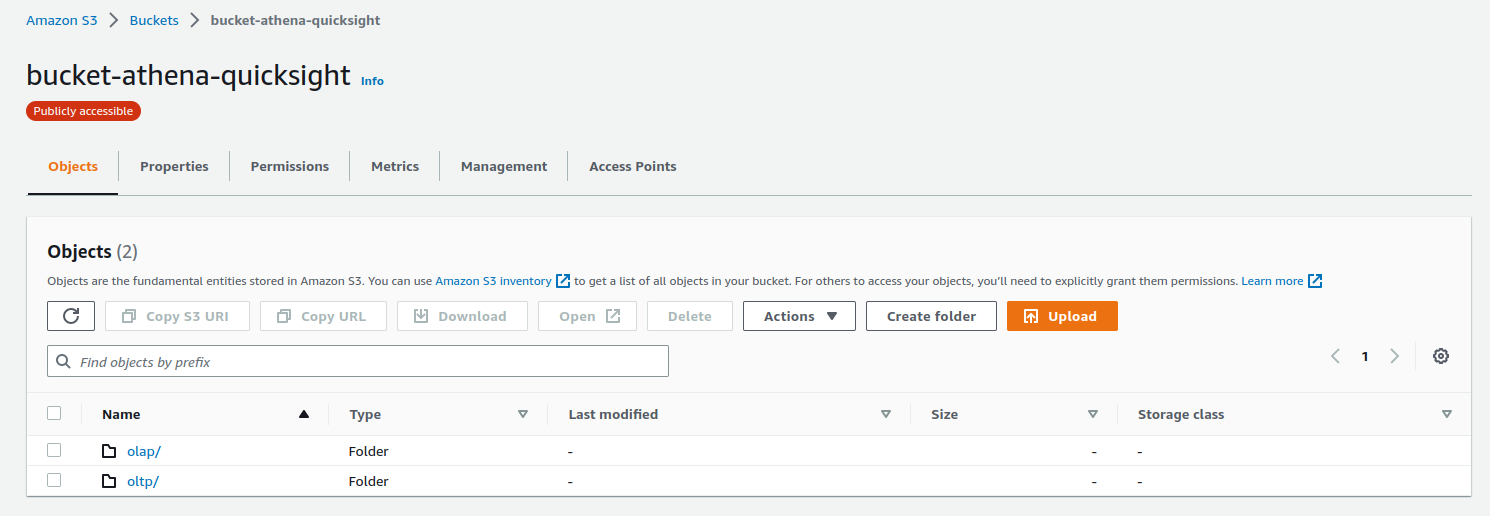

## 2. Convert dataset from OLTP to OLAP

### OLTP Schema
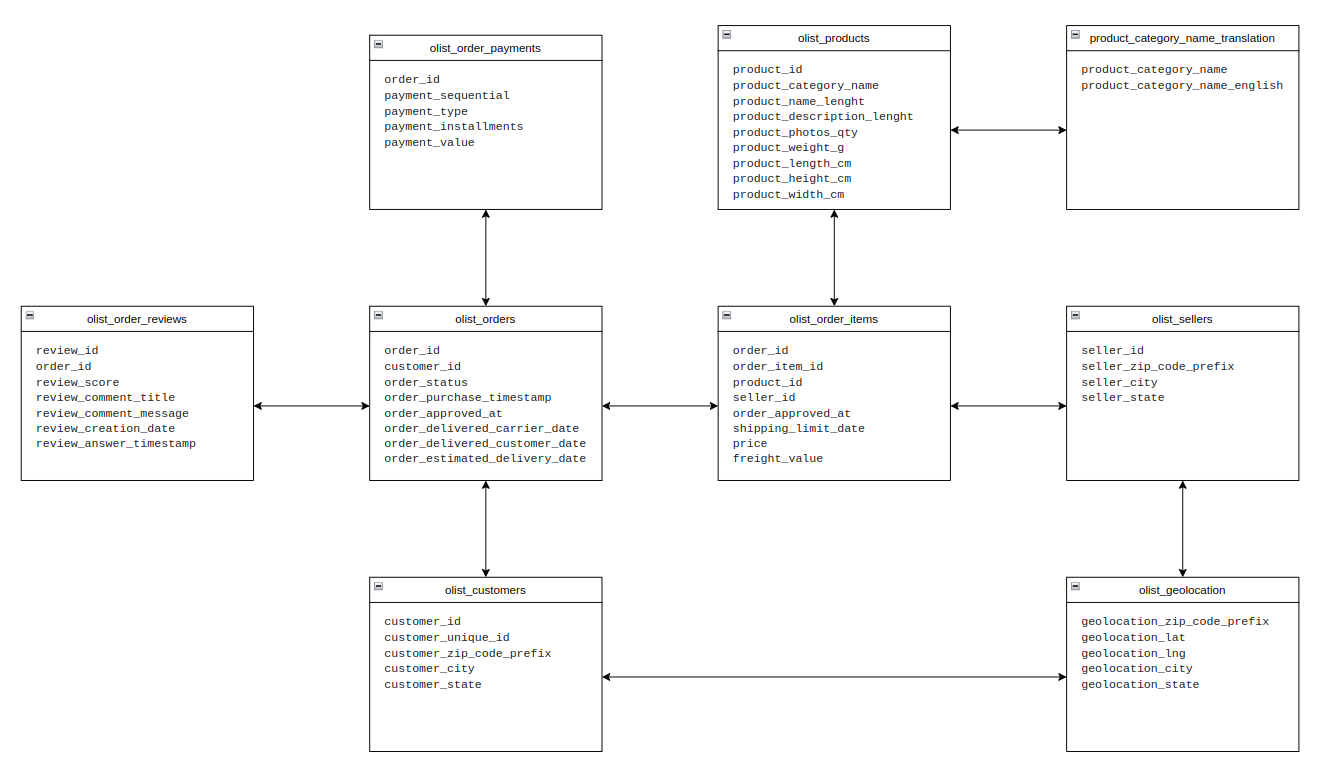

### 2.1 Load the datasets

In [15]:
BUCKET = "bucket-athena-quicksight"

s3 = boto3.resource("s3",
                     aws_access_key_id=KEY,
                     aws_secret_access_key=SECRET,
                     region_name=REGION,)

objects = [obj.key for obj in s3.Bucket(BUCKET).objects.all() if ".csv" in obj.key]
csvs = [s3.Bucket(BUCKET).Object(obj).get() for obj in objects]
customers, geolocs, o_items, o_payments, o_reviews, orders, products, sellers, categories = [pd.read_csv(csv["Body"]) for csv in csvs]

### OLAP Schema
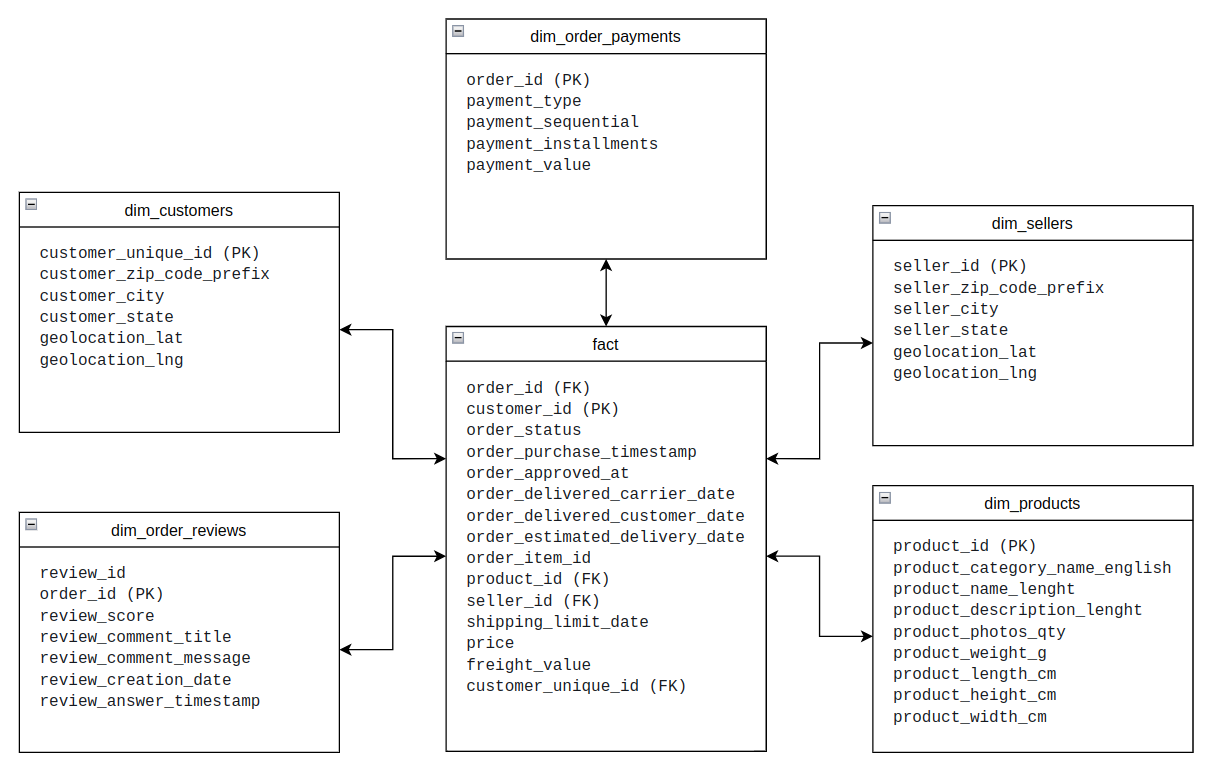

### 2.2 Transfrom the datasets

### 2.2.1 geolocation
Get the averages of `geolocation_lat` and `geolocation_lng` per `geolocation_zip_code_prefix`

In [6]:
geolocation = geolocs.groupby("geolocation_zip_code_prefix").mean()[["geolocation_lat", "geolocation_lng"]]
geolocation.head()

,geolocation_lat,geolocation_lng
geolocation_zip_code_prefix,,
1001,-23.550190,-46.634024
1002,-23.548146,-46.634979
1003,-23.548994,-46.635731
1004,-23.549799,-46.634757
1005,-23.549456,-46.636733


### 2.2.2 dim_customers

In [7]:
# Create the dimension table for customers
dim_customers = pd.merge(customers, geolocation, how="left", left_on="customer_zip_code_prefix", right_on="geolocation_zip_code_prefix")

# Remove customer_id
dim_customers = dim_customers.drop(columns="customer_id")

# Drop customer_unique_id duplicates and keeping the first occurence
dim_customers = dim_customers.drop_duplicates(subset="customer_unique_id", keep="first")

dim_customers


,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,geolocation_lat,geolocation_lng
0,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,-20.498489,-47.396929
1,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,-23.727992,-46.542848
2,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,-23.531642,-46.656289
3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,-23.499702,-46.185233
4,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,-22.975100,-47.142925
...,...,...,...,...,...,...
99436,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP,-23.586003,-46.499638
99437,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP,-23.615830,-46.768533
99438,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE,-3.734569,-38.510534
99439,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS,-29.949839,-51.168494


### 2.2.3 dim_reviews

In [27]:
o_reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01,2018-03-02 10:26:53


In [31]:
dim_reviews = o_reviews

# Convert column data types
dim_reviews["review_creation_date"] = pd.to_datetime(dim_reviews["review_creation_date"])
dim_reviews["review_answer_timestamp"] = pd.to_datetime(dim_reviews["review_answer_timestamp"])

dim_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   review_id                99224 non-null  object        
 1   order_id                 99224 non-null  object        
 2   review_score             99224 non-null  int64         
 3   review_comment_title     11568 non-null  object        
 4   review_comment_message   40977 non-null  object        
 5   review_creation_date     99224 non-null  datetime64[ns]
 6   review_answer_timestamp  99224 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(4)
memory usage: 5.3+ MB


In [32]:
dim_reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01,2018-03-02 10:26:53


### 2.2.4 dim_products

In [67]:
# Convert column data types
dim_products = products.rename(columns={"product_name_lenght": "product_name_length", "product_description_lenght": "product_description_length"})
dim_products["product_name_length"] = dim_products["product_name_length"].astype("Int64")
dim_products["product_description_length"] = dim_products["product_description_length"].astype("Int64")
dim_products["product_photos_qty"] = dim_products["product_photos_qty"].astype("Int64")
dim_products["product_weight_g"] = dim_products["product_weight_g"].astype("Int64")
dim_products["product_length_cm"] = dim_products["product_length_cm"].astype("Int64")
dim_products["product_height_cm"] = dim_products["product_height_cm"].astype("Int64")
dim_products["product_width_cm"] = dim_products["product_width_cm"].astype("Int64")

dim_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   product_id                  32951 non-null  object
 1   product_category_name       32341 non-null  object
 2   product_name_length         32341 non-null  Int64 
 3   product_description_length  32341 non-null  Int64 
 4   product_photos_qty          32341 non-null  Int64 
 5   product_weight_g            32949 non-null  Int64 
 6   product_length_cm           32949 non-null  Int64 
 7   product_height_cm           32949 non-null  Int64 
 8   product_width_cm            32949 non-null  Int64 
dtypes: Int64(7), object(2)
memory usage: 2.5+ MB


In [60]:
categories.head()

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


In [68]:
# Create the dimension table for products
dim_products = pd.merge(dim_products, categories, how="left", on="product_category_name")

# Substitute the prduct category from Portuguese to English
product_category_name_english = dim_products["product_category_name_english"]
dim_products = dim_products.drop(columns=["product_category_name", "product_category_name_english"])
dim_products.insert(loc=1, column="product_category_name", value=product_category_name_english)
dim_products.head()

,product_id,product_category_name,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumery,40,287,1,225,16,10,14
1,3aa071139cb16b67ca9e5dea641aaa2f,art,44,276,1,1000,30,18,20
2,96bd76ec8810374ed1b65e291975717f,sports_leisure,46,250,1,154,18,9,15
3,cef67bcfe19066a932b7673e239eb23d,baby,27,261,1,371,26,4,26
4,9dc1a7de274444849c219cff195d0b71,housewares,37,402,4,625,20,17,13


### 2.2.5 dim_sellers

In [71]:
# Create the dimension table for sellers
dim_sellers = pd.merge(sellers, geolocation, how="left", left_on="seller_zip_code_prefix", right_on="geolocation_zip_code_prefix")
dim_sellers

,seller_id,seller_zip_code_prefix,seller_city,seller_state,geolocation_lat,geolocation_lng
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP,-22.893848,-47.061337
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP,-22.383437,-46.947927
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ,-22.909572,-43.177703
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP,-23.657242,-46.612831
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP,-22.964803,-46.534419
...,...,...,...,...,...,...
3090,98dddbc4601dd4443ca174359b237166,87111,sarandi,PR,-23.448041,-51.869960
3091,f8201cab383e484733266d1906e2fdfa,88137,palhoca,SC,-27.656421,-48.665840
3092,74871d19219c7d518d0090283e03c137,4650,sao paulo,SP,-23.657851,-46.676925
3093,e603cf3fec55f8697c9059638d6c8eb5,96080,pelotas,RS,-31.751072,-52.323202


### 2.2.6 fact

In [85]:
# Create the fact table

# Merge orders and order_items
fact = pd.merge(orders, o_items, how="left", on="order_id")

# Add customers_unique_id 
customers_fact = customers.iloc[:,0:2]
fact = pd.merge(fact, customers_fact, on="customer_id")

fact.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113425 entries, 0 to 113424
Data columns (total 15 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       113425 non-null  object 
 1   customer_id                    113425 non-null  object 
 2   order_status                   113425 non-null  object 
 3   order_purchase_timestamp       113425 non-null  object 
 4   order_approved_at              113264 non-null  object 
 5   order_delivered_carrier_date   111457 non-null  object 
 6   order_delivered_customer_date  110196 non-null  object 
 7   order_estimated_delivery_date  113425 non-null  object 
 8   order_item_id                  112650 non-null  float64
 9   product_id                     112650 non-null  object 
 10  seller_id                      112650 non-null  object 
 11  shipping_limit_date            112650 non-null  object 
 12  price                         

In [86]:
# Convert column data types
fact["order_purchase_timestamp"] = pd.to_datetime(fact["order_purchase_timestamp"])
fact["order_approved_at"] = pd.to_datetime(fact["order_approved_at"])
fact["order_delivered_carrier_date"] = pd.to_datetime(fact["order_delivered_carrier_date"])
fact["order_delivered_customer_date"] = pd.to_datetime(fact["order_delivered_customer_date"])
fact["order_estimated_delivery_date"] = pd.to_datetime(fact["order_estimated_delivery_date"])
fact["order_item_id"] = fact["order_item_id"].astype("Int64")
fact["shipping_limit_date"] = pd.to_datetime(fact["shipping_limit_date"])

fact.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113425 entries, 0 to 113424
Data columns (total 15 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       113425 non-null  object        
 1   customer_id                    113425 non-null  object        
 2   order_status                   113425 non-null  object        
 3   order_purchase_timestamp       113425 non-null  datetime64[ns]
 4   order_approved_at              113264 non-null  datetime64[ns]
 5   order_delivered_carrier_date   111457 non-null  datetime64[ns]
 6   order_delivered_customer_date  110196 non-null  datetime64[ns]
 7   order_estimated_delivery_date  113425 non-null  datetime64[ns]
 8   order_item_id                  112650 non-null  Int64         
 9   product_id                     112650 non-null  object        
 10  seller_id                      112650 non-null  object        
 11  

In [87]:
fact

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_unique_id
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,7c396fd4830fd04220f754e42b4e5bff
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,af07308b275d755c9edb36a90c618231
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,3a653a41f6f9fc3d2a113cf8398680e8
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,1,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20,7c142cf63193a1473d2e66489a9ae977
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,1,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72,72632f0f9dd73dfee390c9b22eb56dd6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113420,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,1,f1d4ce8c6dd66c47bbaa8c6781c2a923,1f9ab4708f3056ede07124aad39a2554,2018-02-12 13:10:37,174.90,20.10,da62f9e57a76d978d02ab5362c509660
113421,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27,1,b80910977a37536adeddd63663f916ad,d50d79cb34e38265a8649c383dcffd48,2017-09-05 15:04:16,205.99,65.02,737520a9aad80b3fbbdad19b66b37b30
113422,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,1,d1c427060a0f73f6b889a5c7c61f2ac4,a1043bafd471dff536d0c462352beb48,2018-01-12 21:36:21,179.99,40.59,5097a5312c8b157bb7be58ae360ef43c
113423,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,2,d1c427060a0f73f6b889a5c7c61f2ac4,a1043bafd471dff536d0c462352beb48,2018-01-12 21:36:21,179.99,40.59,5097a5312c8b157bb7be58ae360ef43c


## 3. Upload the transformed datasets in S3

### 3.1 fact.parquet

In [90]:
fact_buffer = BytesIO()
fact.to_parquet(fact_buffer)
s3.Object(BUCKET, "olap/fact/fact.parquet").put(Body=fact_buffer.getvalue())

{'ResponseMetadata': {'RequestId': 'TY1AHZF660ASWWPE',
  'HostId': 'HwOMJ2DVmOa4dwxvCDlBYDGgxOhqoFywCF4c5wWUWXmMtXS1V1W2vtnjbwQFCh+E4HUPDjQ51HE=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'HwOMJ2DVmOa4dwxvCDlBYDGgxOhqoFywCF4c5wWUWXmMtXS1V1W2vtnjbwQFCh+E4HUPDjQ51HE=',
   'x-amz-request-id': 'TY1AHZF660ASWWPE',
   'date': 'Thu, 01 Dec 2022 16:16:46 GMT',
   'etag': '"9ac48b956480ebc3d6a008247594c516"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"9ac48b956480ebc3d6a008247594c516"'}

### 3.2 dim_customers.parquet

In [35]:
dc_buffer = BytesIO()
dim_customers.to_parquet(dc_buffer)
s3.Object(BUCKET, "olap/dim_customers/dim_customers.parquet").put(Body=dc_buffer.getvalue())

{'ResponseMetadata': {'RequestId': 'RZJDKRG3Y66A0Z07',
  'HostId': 'zCgquYeAk7p3fhOkAXbyUulG/AMbCfRtUTS1k8okpzo6Lgo5tqMCOiIr9FLTYUProCy94qlPzyc=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'zCgquYeAk7p3fhOkAXbyUulG/AMbCfRtUTS1k8okpzo6Lgo5tqMCOiIr9FLTYUProCy94qlPzyc=',
   'x-amz-request-id': 'RZJDKRG3Y66A0Z07',
   'date': 'Thu, 17 Nov 2022 13:32:31 GMT',
   'etag': '"1fecbf2d188d3bc852540e046a1c18a1"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"1fecbf2d188d3bc852540e046a1c18a1"'}

### 3.3 dim_sellers.parquet

In [37]:
ds_buffer = BytesIO()
dim_sellers.to_parquet(ds_buffer)
s3.Object(BUCKET, "olap/dim_sellers/dim_sellers.parquet").put(Body=ds_buffer.getvalue())

{'ResponseMetadata': {'RequestId': 'YYJGZFZFGRRKKZ37',
  'HostId': '1Pzx92AThcaAgbQDmb52ePE4FylyQgw2P3q7DF/u0/XckzxpZrFZiUhetBqB6EKT1QYS2qXwNog=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': '1Pzx92AThcaAgbQDmb52ePE4FylyQgw2P3q7DF/u0/XckzxpZrFZiUhetBqB6EKT1QYS2qXwNog=',
   'x-amz-request-id': 'YYJGZFZFGRRKKZ37',
   'date': 'Thu, 17 Nov 2022 13:33:41 GMT',
   'etag': '"5354e8687fcb37e1a5b8a4dac9110535"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"5354e8687fcb37e1a5b8a4dac9110535"'}

### 3.4 dim_products.parquet

In [69]:
dp_buffer = BytesIO()
dim_products.to_parquet(dp_buffer)
s3.Object(BUCKET, "olap/dim_products/dim_products.parquet").put(Body=dp_buffer.getvalue())

{'ResponseMetadata': {'RequestId': '4Q9VM0D1Z4D5APF9',
  'HostId': 'pWMEcwsXgfIjEVnmMRdxIBn3fFVEjOA4wG1aQt9r1RgdRK8o8dVah2GUcBS0I1QMHAyxZE02ZNs=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'pWMEcwsXgfIjEVnmMRdxIBn3fFVEjOA4wG1aQt9r1RgdRK8o8dVah2GUcBS0I1QMHAyxZE02ZNs=',
   'x-amz-request-id': '4Q9VM0D1Z4D5APF9',
   'date': 'Thu, 01 Dec 2022 15:14:59 GMT',
   'etag': '"24dadf7e4500acd672c63ae296c1cc26"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"24dadf7e4500acd672c63ae296c1cc26"'}

### 3.5 dim_order_payments.parquet

In [39]:
dop_buffer = BytesIO()
o_payments.to_parquet(dop_buffer)
s3.Object(BUCKET, "olap/dim_order_payments/dim_order_payments.parquet").put(Body=dop_buffer.getvalue())

{'ResponseMetadata': {'RequestId': '6MX10NTP2Y1PTW02',
  'HostId': 'CkcobRK8mGfz+xrgvk4EOD4VJT3YdLYTHUpf9Yd/r5/kVyeabMNAtI/7k3l7YsPa+Bs4mY7jgeA=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'CkcobRK8mGfz+xrgvk4EOD4VJT3YdLYTHUpf9Yd/r5/kVyeabMNAtI/7k3l7YsPa+Bs4mY7jgeA=',
   'x-amz-request-id': '6MX10NTP2Y1PTW02',
   'date': 'Thu, 17 Nov 2022 13:33:46 GMT',
   'etag': '"07f19b45174e249d81c7ae36b094f415"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"07f19b45174e249d81c7ae36b094f415"'}

### 3.6 dim_order_reviews.parquet

In [35]:
dor_buffer = BytesIO()
dim_reviews.to_parquet(dor_buffer)
s3.Object(BUCKET, "olap/dim_order_reviews/dim_order_reviews.parquet").put(Body=dor_buffer.getvalue())

{'ResponseMetadata': {'RequestId': 'B243X6TR4PFTPVE6',
  'HostId': '8F/jVnCXNhDzZE8/i2uwj+0UuLVTmLVPZ0yGYmziK+RYfREzSIGBh+0GX38ndO3uRmqbQ0OUArwXlonaTSS6IQ==',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': '8F/jVnCXNhDzZE8/i2uwj+0UuLVTmLVPZ0yGYmziK+RYfREzSIGBh+0GX38ndO3uRmqbQ0OUArwXlonaTSS6IQ==',
   'x-amz-request-id': 'B243X6TR4PFTPVE6',
   'date': 'Thu, 01 Dec 2022 14:05:08 GMT',
   'etag': '"4f457ed0bf41b9439308ef1f207f2c69"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"4f457ed0bf41b9439308ef1f207f2c69"'}

### 3.7 Confirm uploaded parquet files
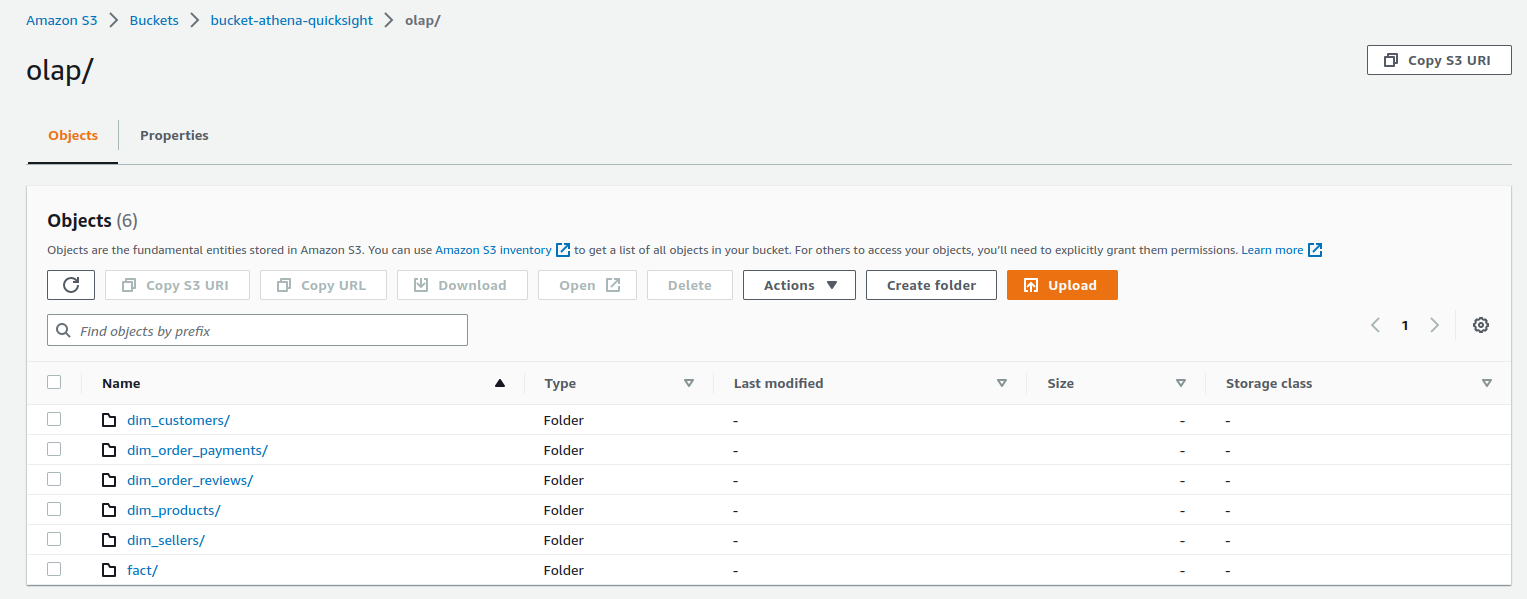

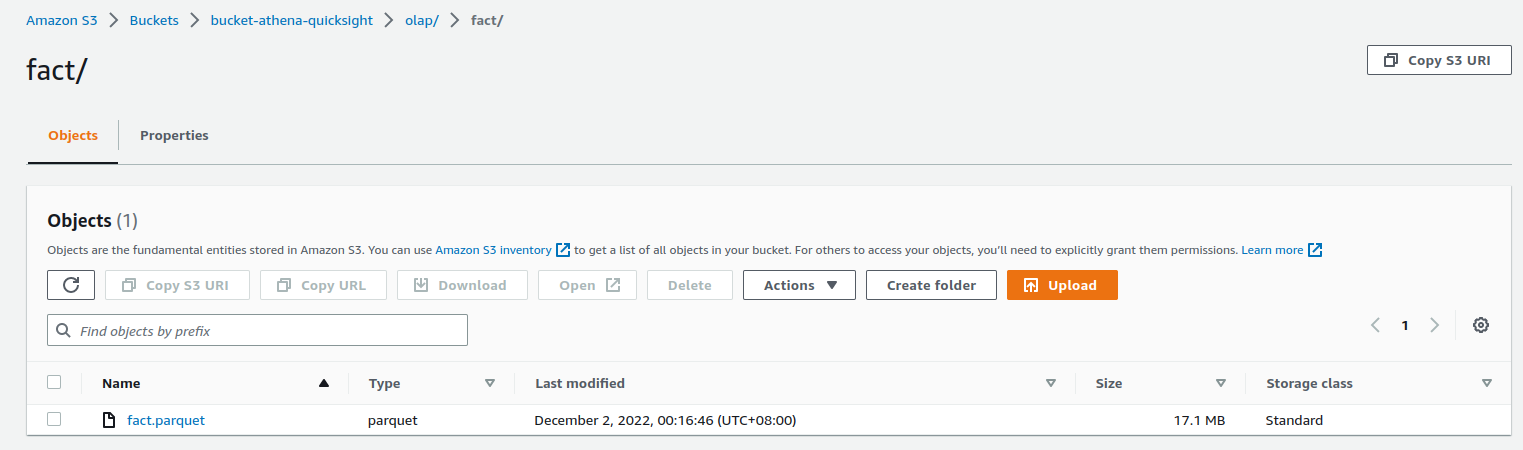

## 4. Query parquet files from S3 to Athena

After uploading the parquet files, these can be queried by running a crawler using __AWS Glue__ or by manually specifying the schema of each datasets. Using AWS Glue, it automatically sets up the schema of each datasets. The image below is a sample of my crawlers that I used to query Covid-19 datasets.
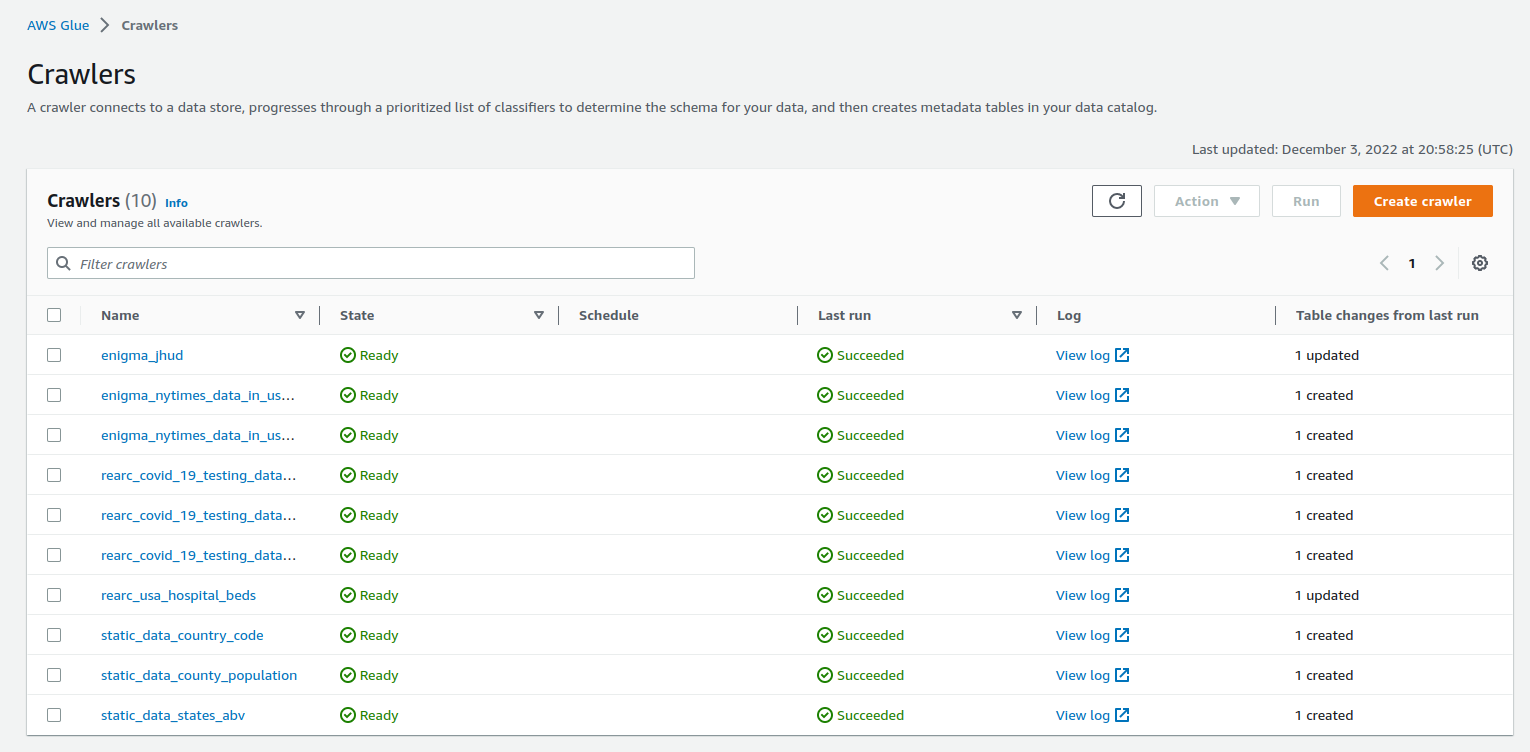

However, in this project, I tried to do the manual approach and here are the queried datasets.
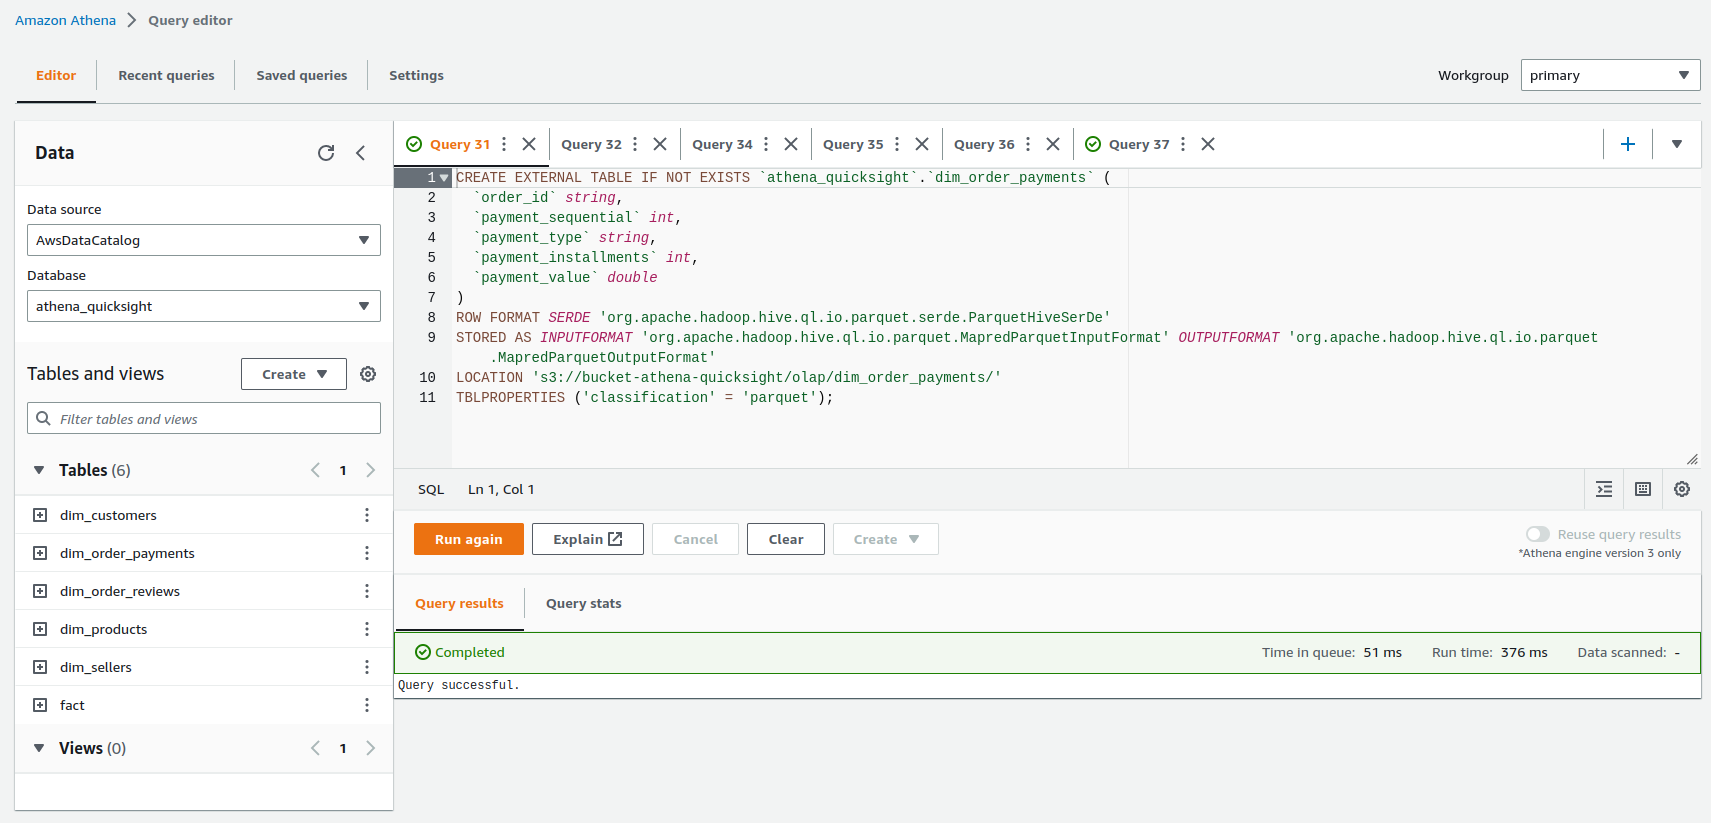

## 5. Build a dashboard in Quicksight

### 5.1 Create new datasets
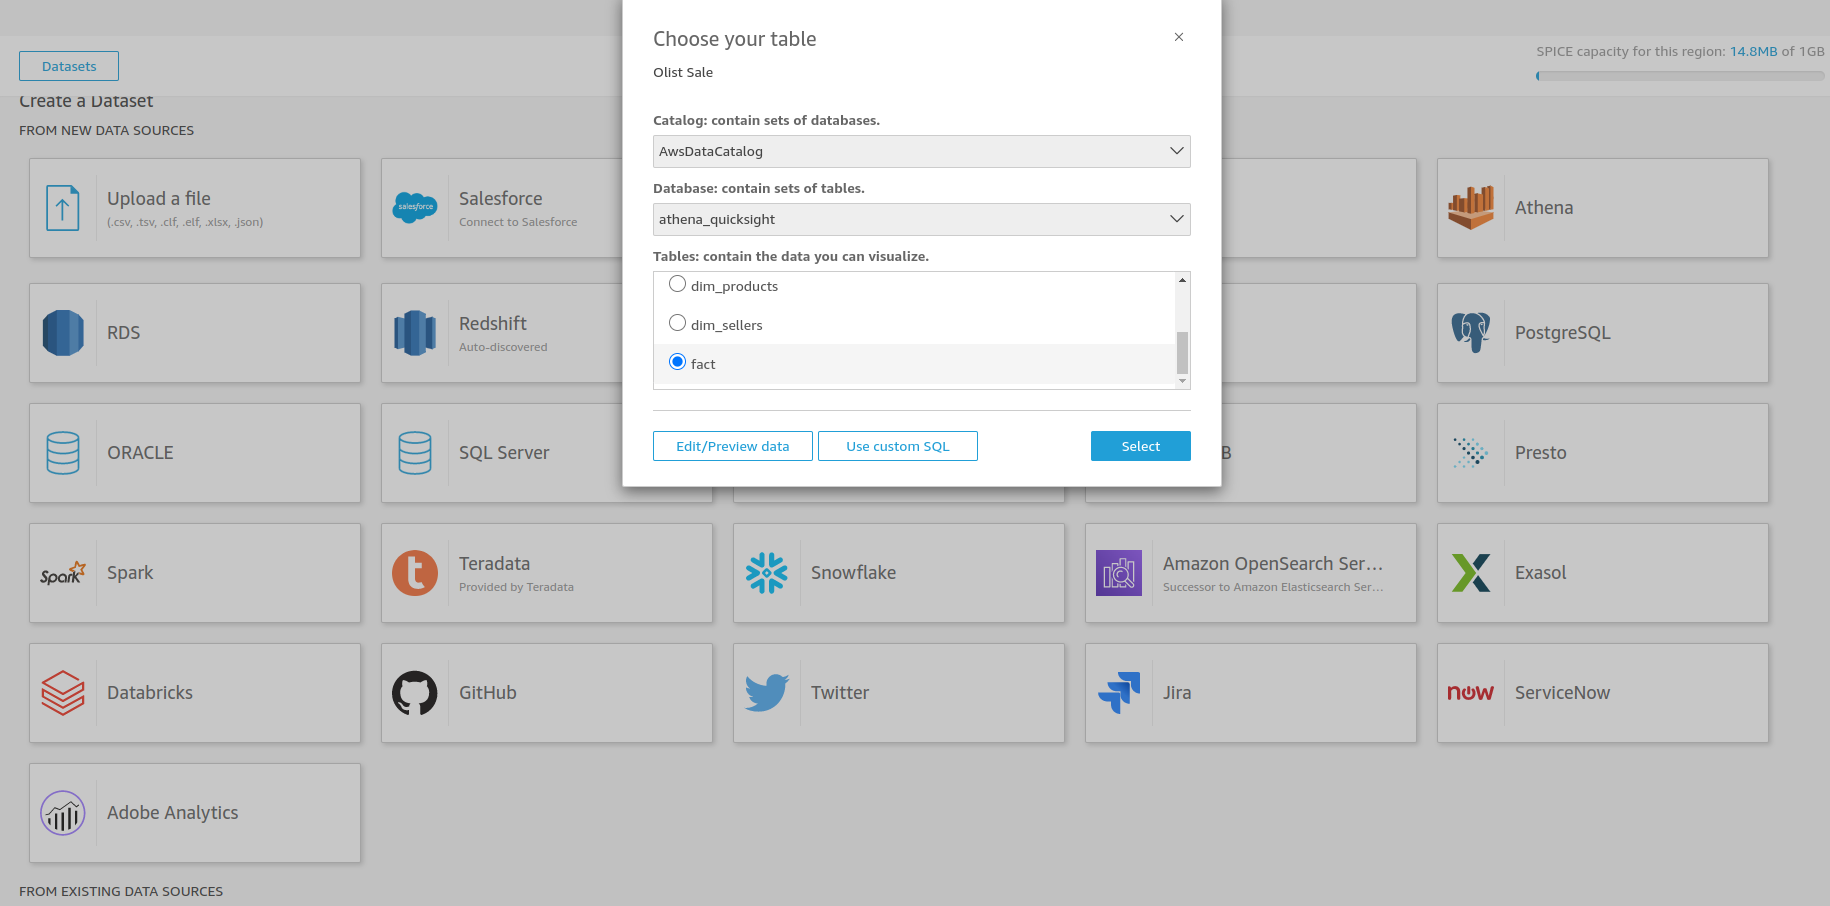

- Here are the created datasets.

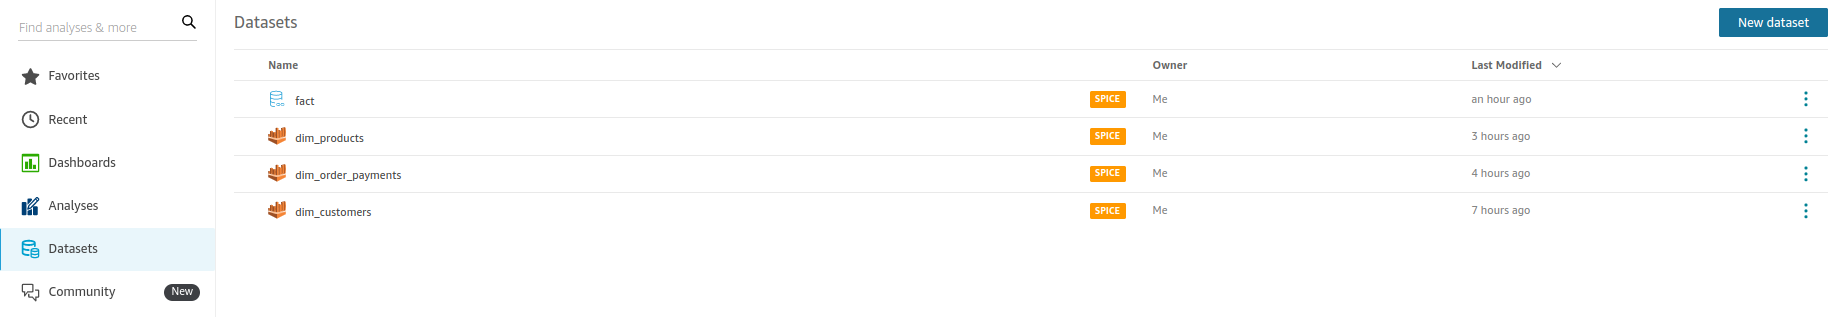

- Merge OLAP datasets in preparation for visualization

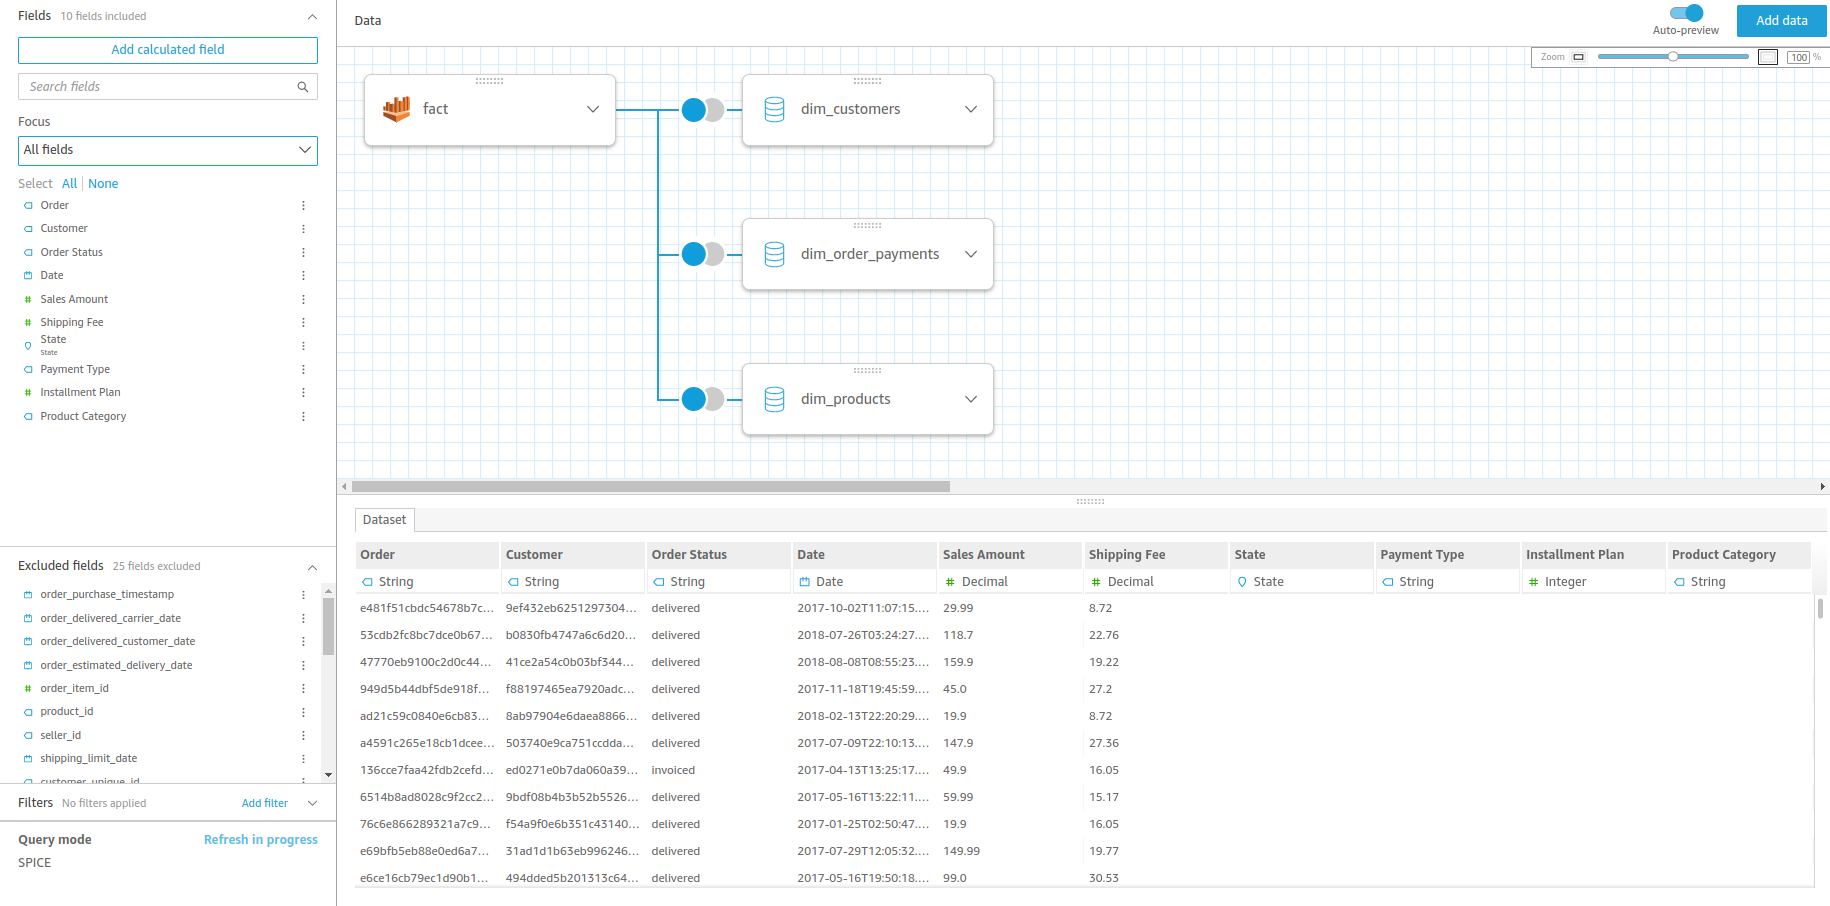

### 5.2 Create analyses from datasets

### 5.2.1  Analysis: Order and Customer
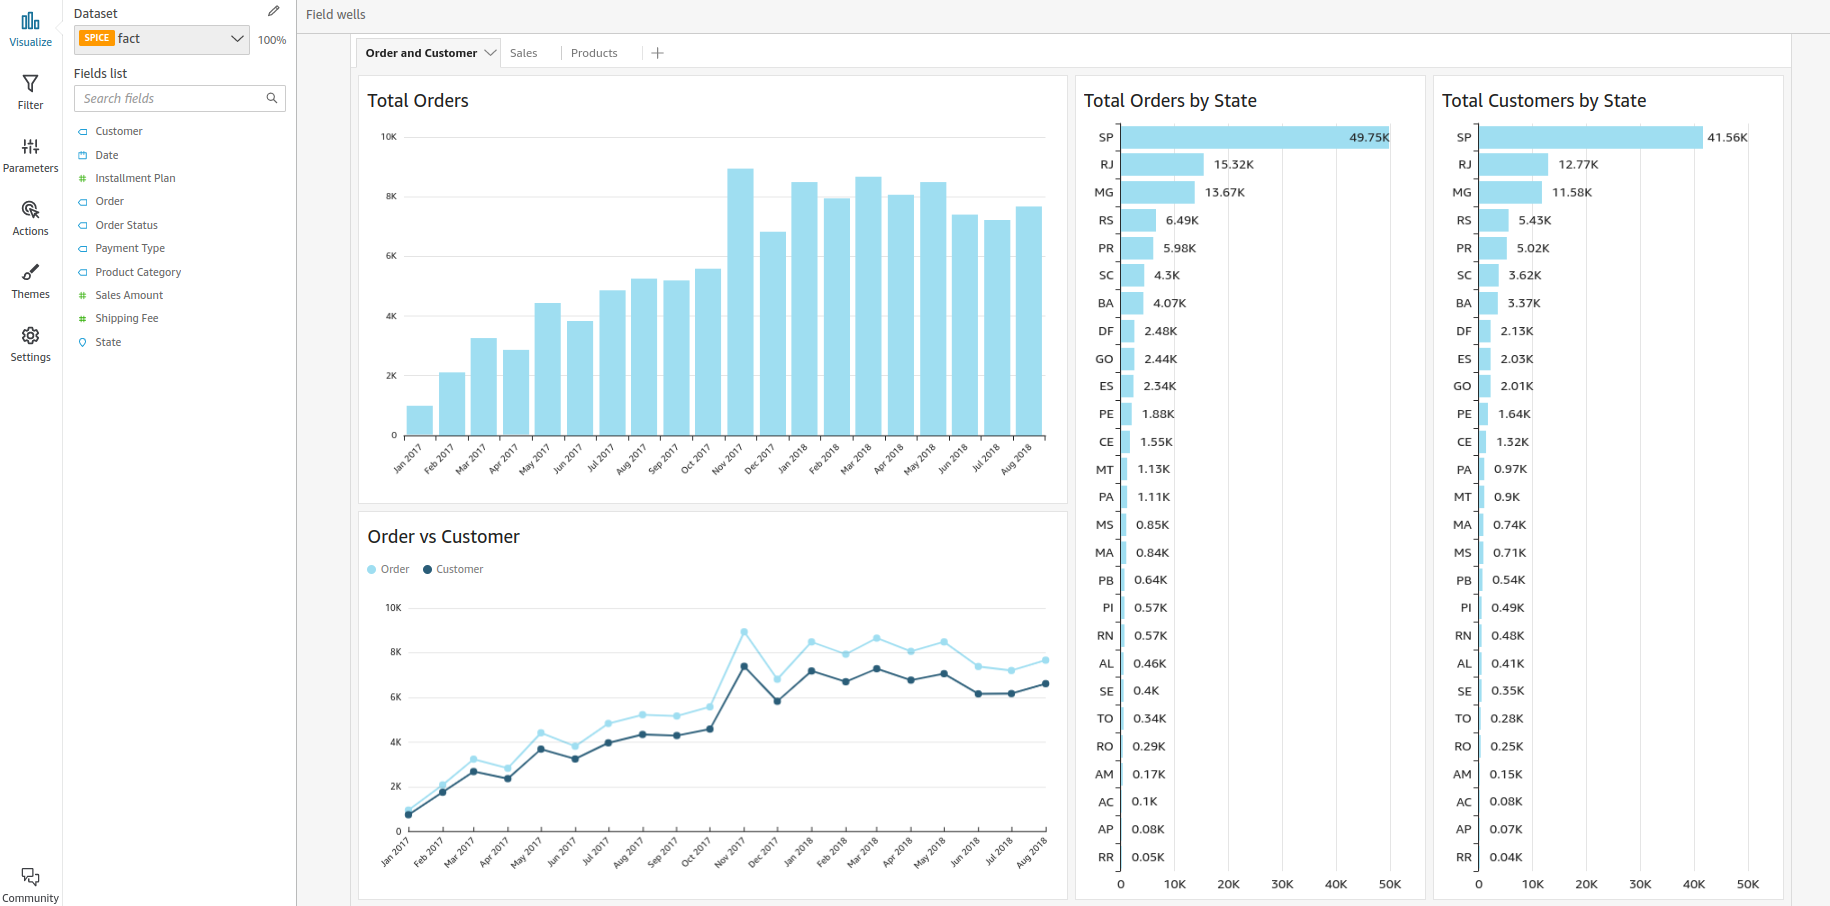

### 5.2.2 Analysis: Customer and Sales
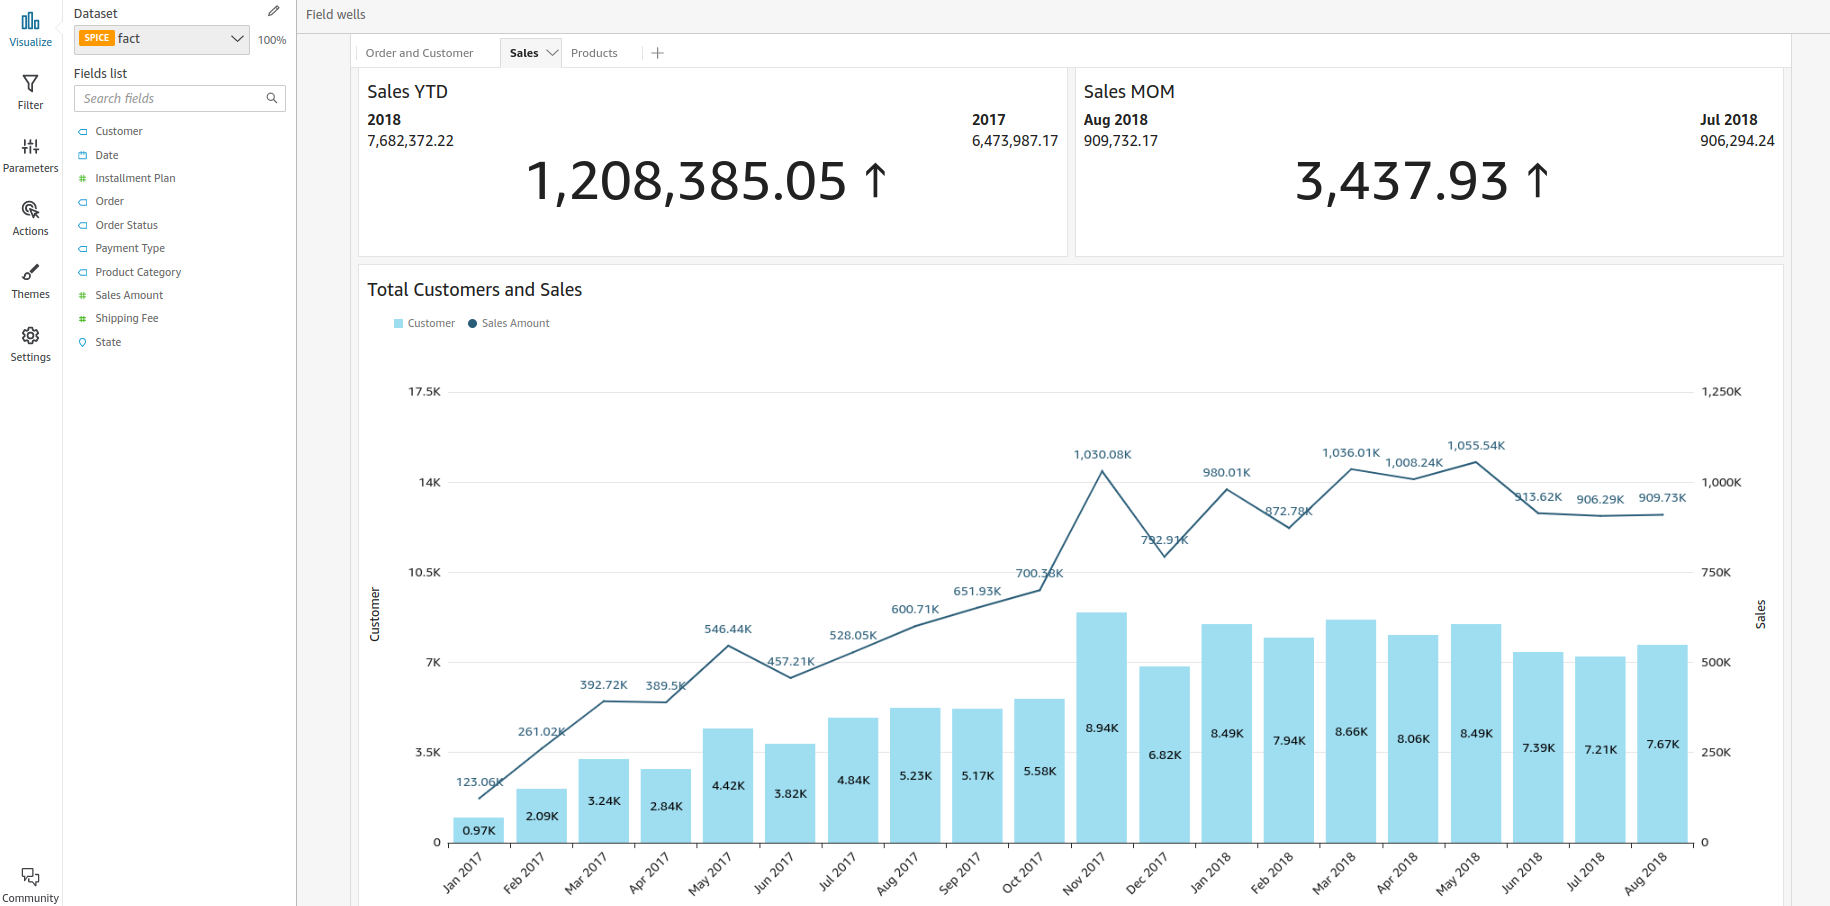

### 5.2.3 Analysis: Sales by State, Payment Method, and Installment Plan
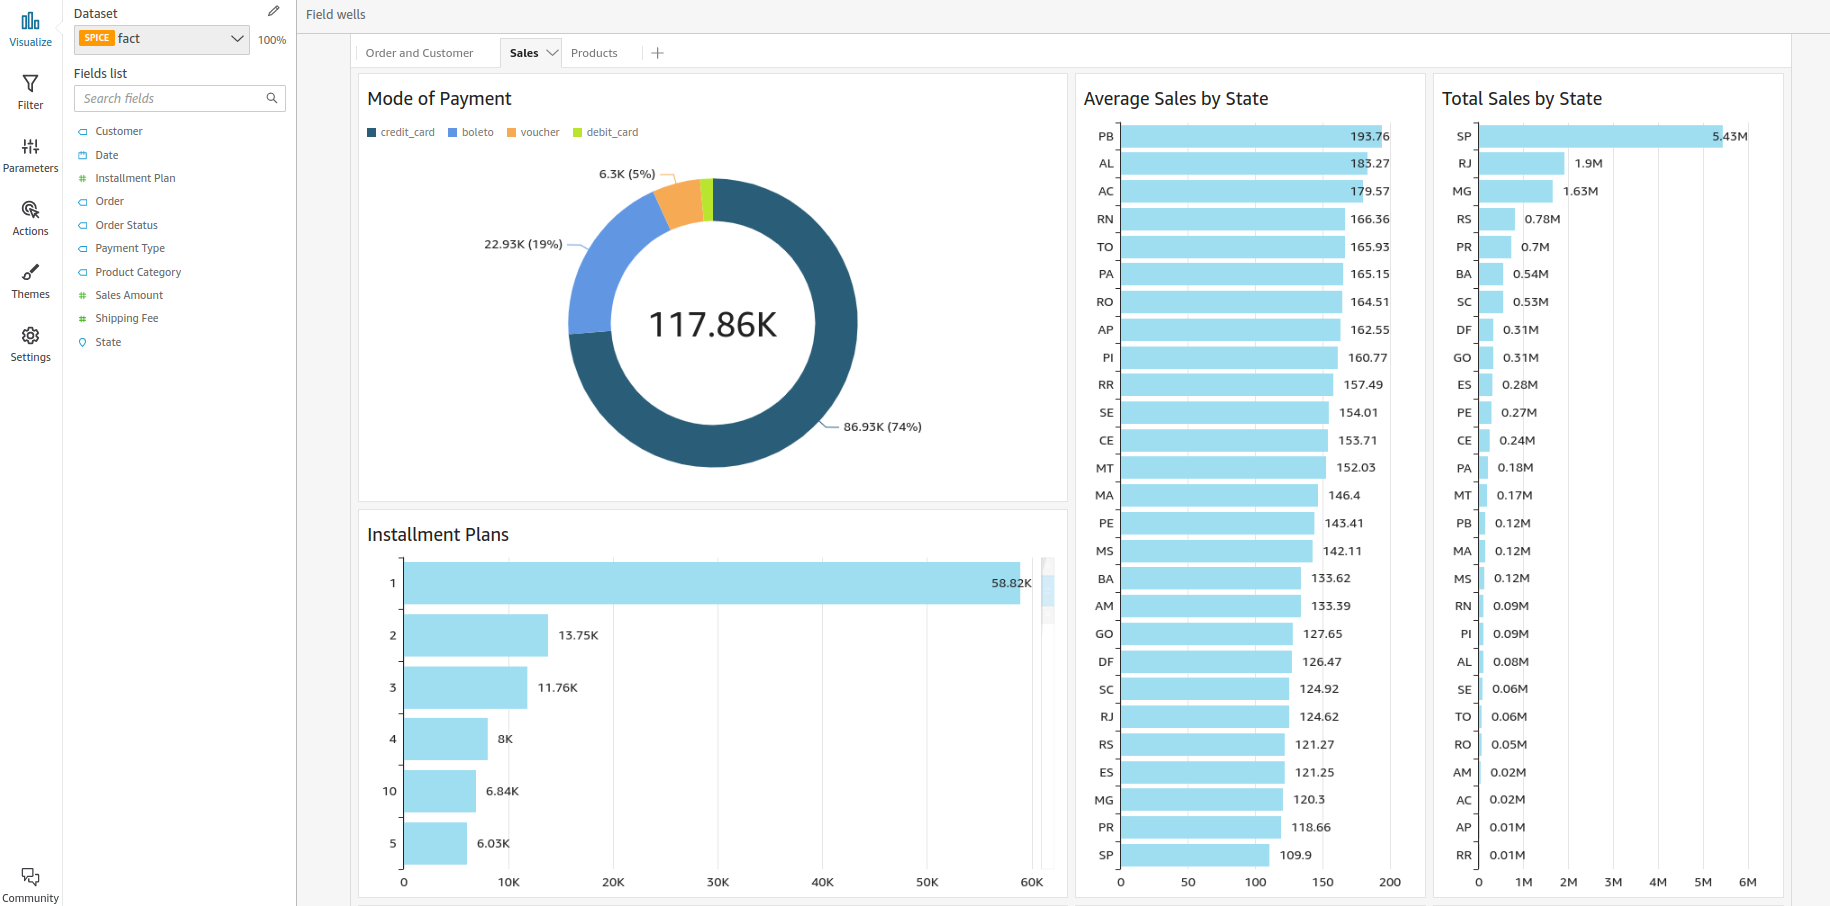

### 5.2.4 Analysis: Shipping Fee
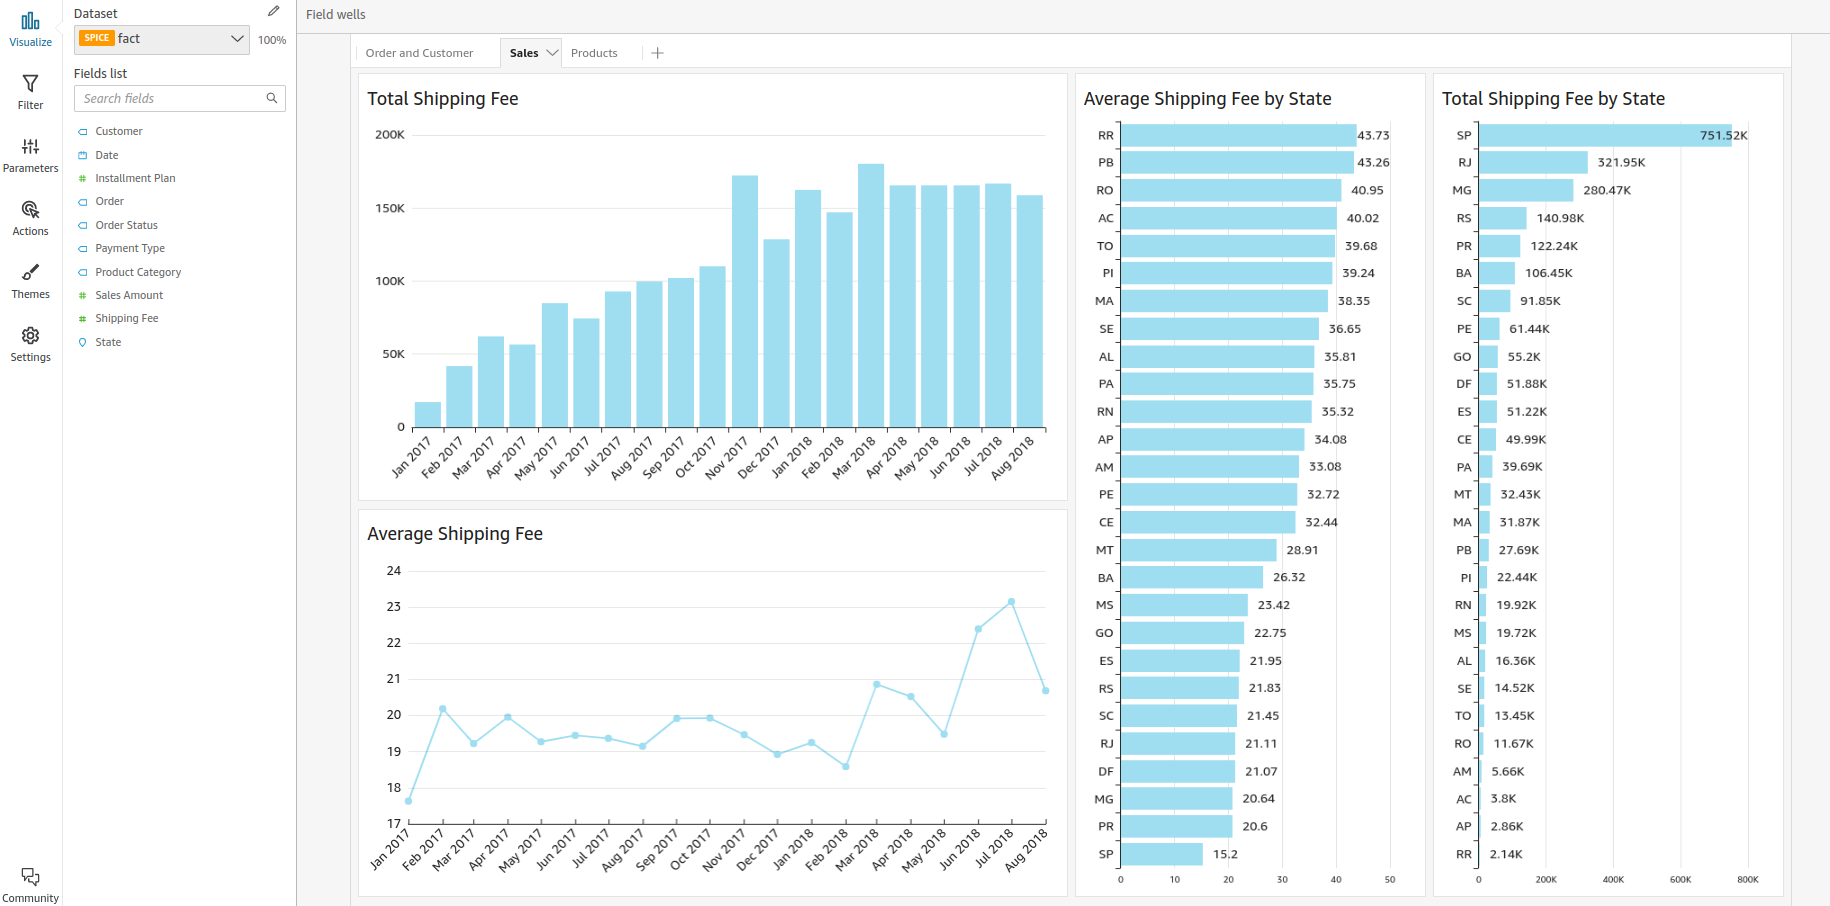

### 5.2.5 Analysis: Product Category and Order Status
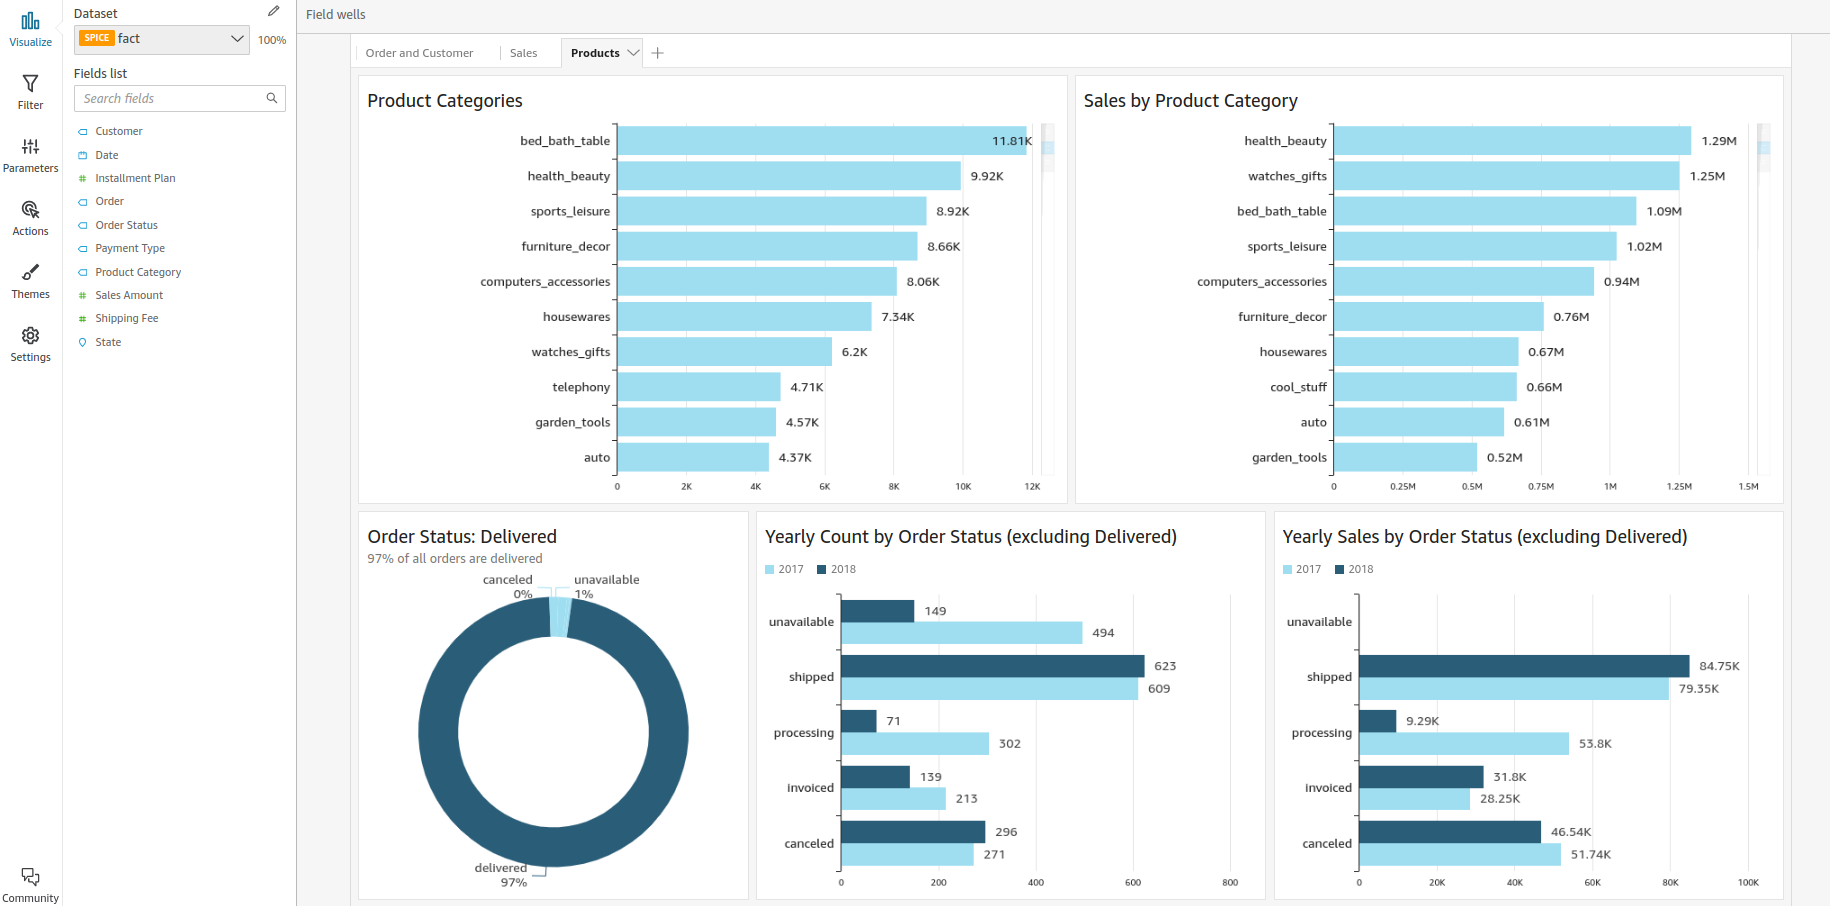